### Поиск аномалий во временных рядах. Современные средства анализа временных рядов.

In [ ]:
!pip install sesd

  Preparing metadata (setup.py) ... done
  Created wheel for sesd: filename=sesd-0.2-py3-none-any.whl size=4691 sha256=b82eb4e9c5bac2c4d04da805fda6dc7e75f8069634a6c0ec3ef0c2fd3d51cb3f
  Stored in directory: /root/.cache/pip/wheels/0a/51/4f/73423b93bc81cfa0419a3e90a74d40c7f8220c7cba80a8cedc
Successfully built sesd


In [ ]:
!pip install rrcf -q

  Preparing metadata (setup.py) ... done


In [ ]:
pip install etna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 9.3 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 85.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 93.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.0 MB/s eta 0:00:00
  Attempting uninstall: typer
    Found existing installation: typer 0.15.1
    Uninstalling typer-0.15.1:
      Successfully uninstalled typer-0.15.1
  Attempting uninstall: Deprecated
    Found existing installation: Deprecated 1.2.15
    Uninstalling Deprecated-1.2.15:
      Successfully uninstalled Deprecated-1.2.15
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.3
    Uninstalling p

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler


import scipy.stats as sps
import rrcf

from etna.datasets import TSDataset
from etna.models import CatBoostPerSegmentModel
from etna.models import CatBoostMultiSegmentModel
from etna.transforms import LagTransform
from etna.transforms import DateFlagsTransform
from etna.transforms import FourierTransform
from etna.transforms import MeanTransform
from etna.transforms import YeoJohnsonTransform
from etna.metrics import MSE
from etna.metrics import MAE
from etna.metrics import MAPE
from etna.transforms import SegmentEncoderTransform
from etna.analysis import plot_forecast
from etna.pipeline import Pipeline

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.3, palette='Set2')

---

### Задача 1

[Существует](https://disk.yandex.ru/d/d9uxKFsst-YBkA) часть информации о визитах пользователей на сайте Физтех.Статистики начиная с 2020 года по данным Яндекс.Метрики. Визит — последовательность действий пользователя на сайте, которая
начинается на некоторой странице сайта, содержит в себе переходы по ссылкам (и другие действия), и
заканчивается на какой-то, возможно, другой страницей сайта. Визит считается завершенным, если
активность отсутствует в течение некоторого времени, обычно — 30 минут.

Для начала загрузим данные. Нас будет интересовать общее количество посещений по дням. Построим график временного ряда.

In [ ]:
data = pd.read_csv(
    "miptstats_metrica.tsv",
    sep="\t",
)

for column in data.columns:
    col = column.replace("ym:s:", "")
    data.rename(columns={column: col}, inplace=True)

data["dateTimeUTC"] = pd.to_datetime(data["dateTimeUTC"])

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387353 entries, 0 to 387352
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   visitID              387353 non-null  float64       
 1   clientID             387353 non-null  uint64        
 2   dateTimeUTC          387353 non-null  datetime64[ns]
 3   startURL             387338 non-null  object        
 4   endURL               387338 non-null  object        
 5   pageViews            387353 non-null  int64         
 6   visitDuration        387353 non-null  int64         
 7   isNewUser            387353 non-null  int64         
 8   bounce               387353 non-null  int64         
 9   regionCountry        382478 non-null  object        
 10  regionCity           326661 non-null  object        
 11  networkType          43035 non-null   object        
 12  browserLanguage      327934 non-null  object        
 13  browserCountry

In [ ]:
data.columns

Index(['visitID', 'clientID', 'dateTimeUTC', 'startURL', 'endURL', 'pageViews',
       'visitDuration', 'isNewUser', 'bounce', 'regionCountry', 'regionCity',
       'networkType', 'browserLanguage', 'browserCountry', 'mobilePhone',
       'operatingSystemRoot', 'browser', 'browserEngine', 'screenOrientation',
       'screenWidth', 'screenHeight', 'windowClientWidth',
       'windowClientHeight'],
      dtype='object')

In [ ]:
data['date'] = data['dateTimeUTC'].dt.floor('D')

daily_visits = data.groupby('date')['visitID'].count().reset_index()
daily_visits.columns = ['date', 'total_visits']

# Создание полного диапазона дат (на случай пропусков)
date_range = pd.date_range(
    start=daily_visits['date'].min(),
    end=daily_visits['date'].max(),
    freq='D'
)
daily_visits.head(5)

,date,total_visits
0,2020-01-01,16
1,2020-01-02,28
2,2020-01-03,35
3,2020-01-04,36
4,2020-01-05,29


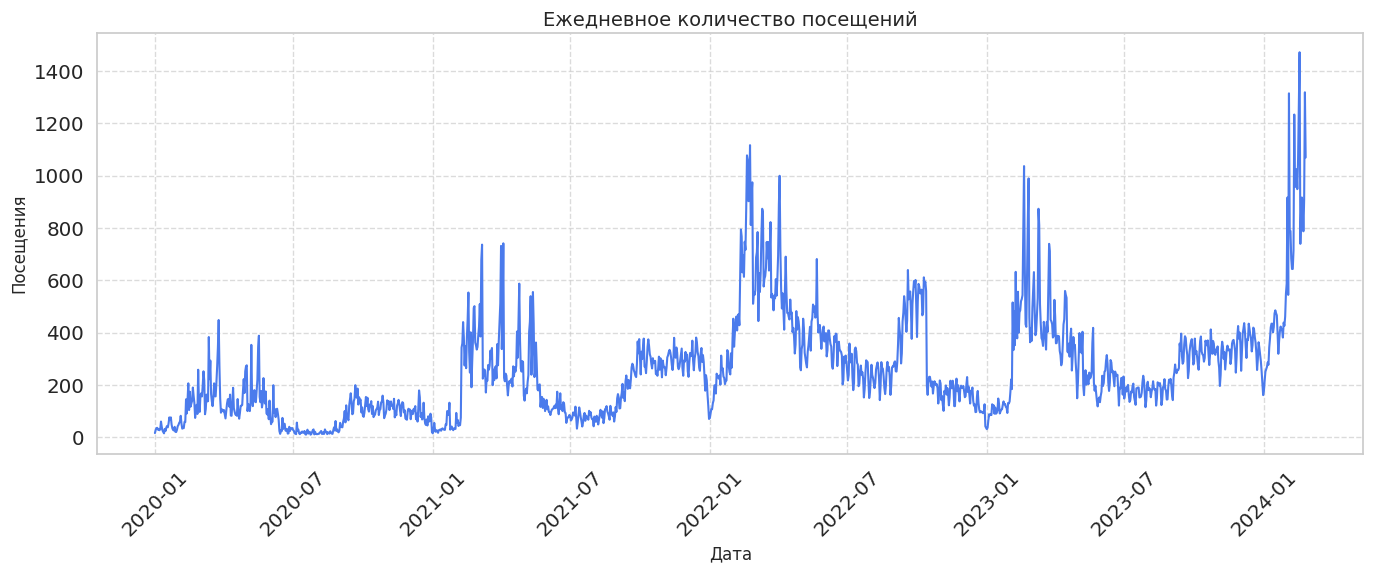

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(daily_visits['date'], daily_visits['total_visits'], color='#4B7BEC', linewidth=1.5)
plt.title('Ежедневное количество посещений', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Посещения', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

По графику можно сказать следующее:
* имеет сезонность и тренд, причем возрастает на середину семестра, а летом и зимой низкая, однако есть некоторые аномалии с очень большим проседанием или повышением графиков

Также посмотрим на график визитов агрегированный по неделям:

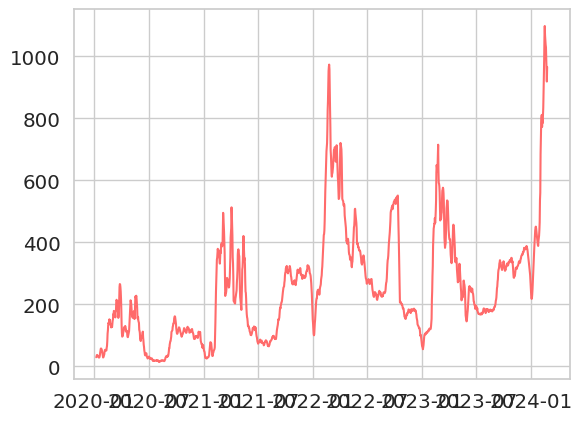

In [ ]:
daily_visits['MA_7'] = daily_visits['total_visits'].rolling(window=7).mean()
plt.plot(daily_visits['date'], daily_visits['MA_7'], color='#FF6B6B', label='Скользящее среднее (7 дней)')

Видно, что график стал менее шумным, однако иногда все равно прослеживаются аномалии которые будем детектировать в следующем пункте

Задачи:
* Найти аномалии в предоставленных временных рядах постфактум, то есть построить оффлайн-модель. Попробуйте применить методы на основе фильтрации или метрические методы с использованием, например, DBSCAN.
* Построить онлайн-модель детектирования аномалий.

Попробуем также как-то проинтерпретировать найденные аномалии.

Оффлайн детекция аномалий:

In [ ]:
daily_visits.columns

Index(['date', 'total_visits', 'MA_7'], dtype='object')

In [ ]:
daily_visits['day_of_week'] = daily_visits['date'].dt.dayofweek
daily_visits['rolling_7d'] = daily_visits['total_visits'].rolling(14).mean().fillna(0)

scaler = StandardScaler()
X = scaler.fit_transform(daily_visits[['total_visits', 'day_of_week', 'rolling_7d']])

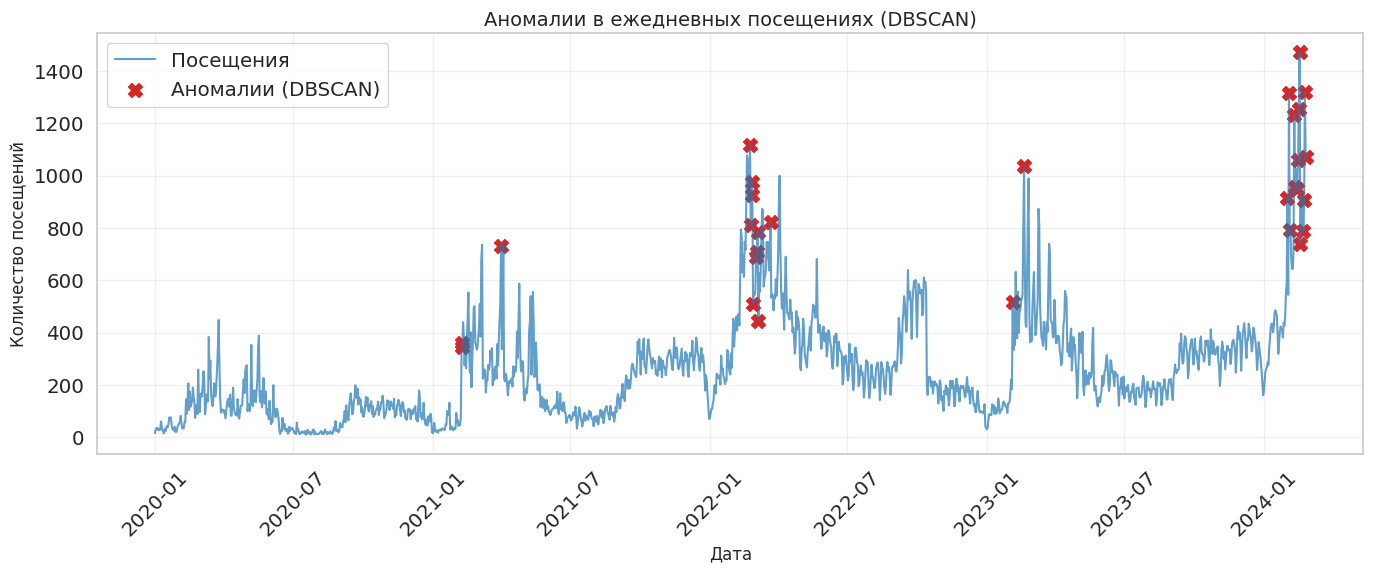

In [ ]:
dbscan = DBSCAN(eps=0.6, min_samples=3)
daily_visits['cluster'] = dbscan.fit_predict(X)

daily_visits['is_anomaly'] = (daily_visits['cluster'] == -1)

plt.figure(figsize=(14, 6))

plt.plot(daily_visits['date'], daily_visits['total_visits'],
         label='Посещения', color='#1f77b4', alpha=0.7)

plt.scatter(
    daily_visits.loc[daily_visits['is_anomaly'], 'date'],
    daily_visits.loc[daily_visits['is_anomaly'], 'total_visits'],
    color='#d62728', marker='X', s=100, label='Аномалии (DBSCAN)'
)

plt.title('Аномалии в ежедневных посещениях (DBSCAN)', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество посещений', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
anomaly_report = daily_visits[daily_visits['is_anomaly']][['date', 'total_visits', 'day_of_week']].sort_values('date')

print("Обнаруженные аномалии:")
print(anomaly_report.to_string(index=False))

Обнаруженные аномалии:
      date  total_visits  day_of_week
2021-02-08           343            0
2021-02-09           359            1
2021-04-01           731            3
2022-02-23          1116            2
2022-02-24           811            3
2022-02-25           925            4
2022-02-26           974            5
2022-02-27           510            6
2022-03-03           687            3
2022-03-04           707            4
2022-03-05           784            5
2022-03-06           444            6
2022-03-22           822            1
2023-02-04           515            5
2023-02-19          1036            6
2024-02-01           916            3
2024-02-03          1314            5
2024-02-04           790            6
2024-02-10          1233            5
2024-02-11           956            6
2024-02-14           948            2
2024-02-15          1061            3
2024-02-16          1255            4
2024-02-17          1471            5
2024-02-18           739   

**Интерпретация аномалий:**

Сначала заметим что большинство аномалий, при использовании DBSCAN связаны с большим количеством визитов, причем все такие аномалии происходят в четных семестрах
* Причем много аномалий приходится на начало февраля когда стартует Введение в АД и физтех.datascience, что объясняет большой приток пользователей, которые закрывают курс
* Также объясняется аномалия того, что слишком мало пользователей: это происходит примерно тогда же когда начинаются контрольные по другим предметам\др фпми\др физтеха

Онлайн детекция аномалий:

Воспользуемся методом изолирующего леса

In [ ]:
daily_visits.drop(columns = ['cluster', 'is_anomaly'], inplace = True)
daily_visits

,date,total_visits,MA_7,day_of_week,rolling_7d
0,2020-01-01,16,NaN,2,0.000000
1,2020-01-02,28,NaN,3,0.000000
2,2020-01-03,35,NaN,4,0.000000
3,2020-01-04,36,NaN,5,0.000000
4,2020-01-05,29,NaN,6,0.000000
...,...,...,...,...,...
1512,2024-02-21,894,1029.571429,2,978.285714
1513,2024-02-22,787,990.428571,3,988.571429
1514,2024-02-23,906,940.571429,4,1002.285714
1515,2024-02-24,1318,918.714286,5,1008.357143


In [ ]:
num_trees = 100
shingle_size = 7
tree_size = 256

forest = []
for _ in range(num_trees):
    tree = rrcf.RCTree()
    forest.append(tree)

In [ ]:
points = rrcf.shingle(daily_visits['total_visits'], size=shingle_size)

# Словарь степени аномальности каждой точки
avg_codisp = {}

# Для каждого окна
for index, point in enumerate(points):
    # для каждого дерева
    for tree in forest:
        # если дерево уже большое
        if len(tree.leaves) > tree_size:
            # удалим самую старую окно-точку
            tree.forget_point(index - tree_size)
        # добавим новую окно-точку
        tree.insert_point(point, index=index)
        # вычислим степень аномальности нового окна
        new_codisp = tree.codisp(index)
        # и усредним по всем деревьям
        if not index in avg_codisp:
            avg_codisp[index] = 0
        avg_codisp[index] += new_codisp / num_trees

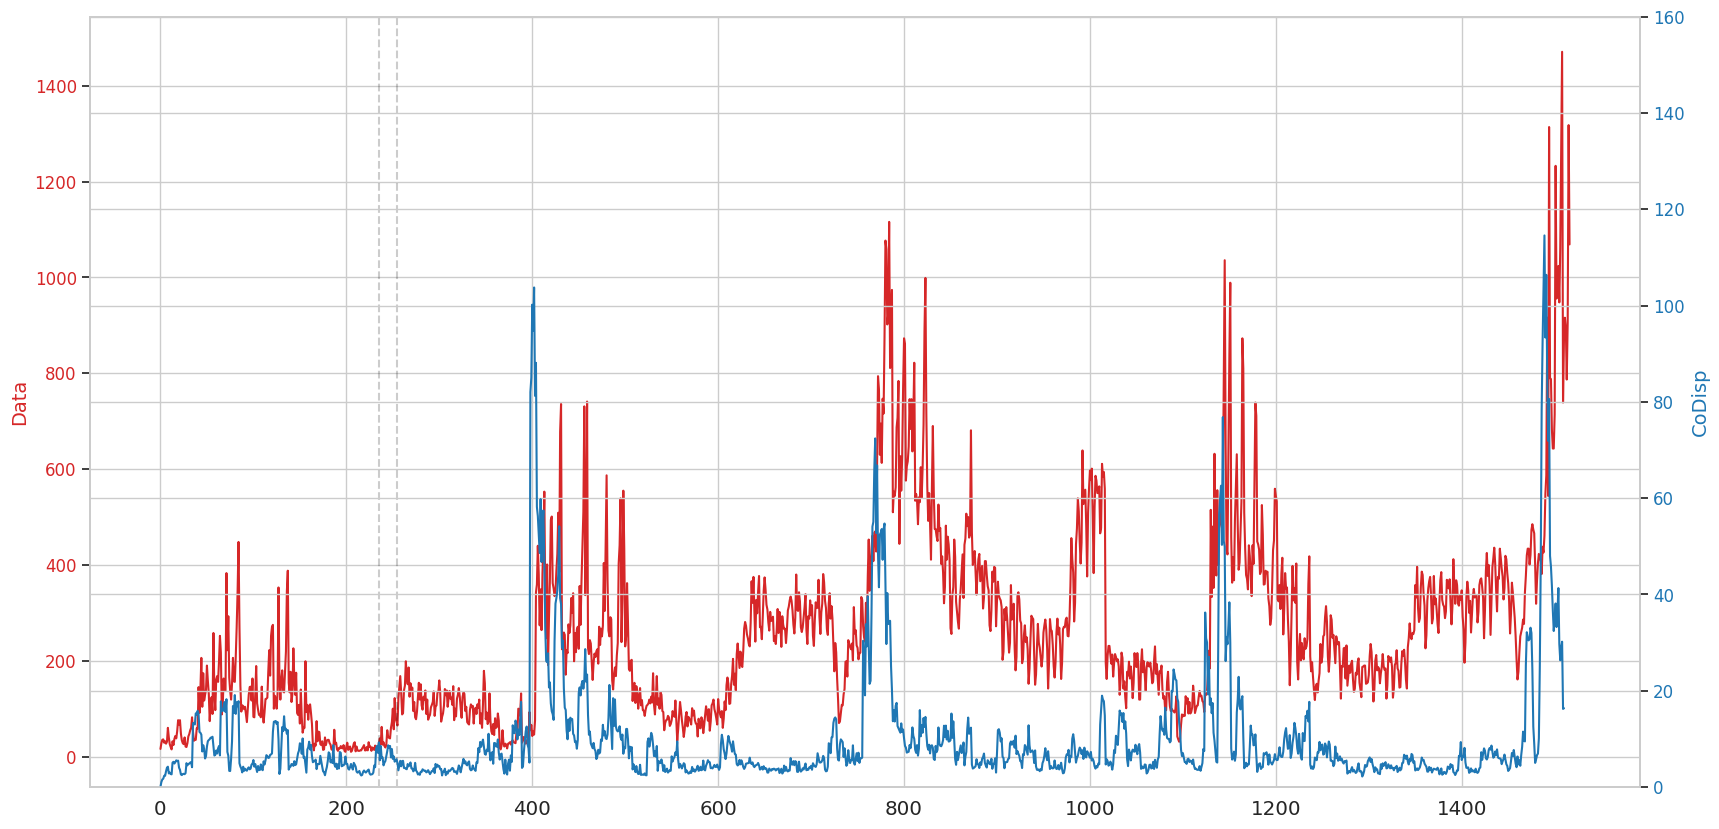

In [ ]:
fig, ax1 = plt.subplots(figsize=(20, 10))

color = "tab:red"
ax1.set_ylabel("Data", color=color, size=14)
ax1.plot(daily_visits['total_visits'], color=color)
ax1.tick_params(axis="y", labelcolor=color, labelsize=12)

ax2 = ax1.twinx()
color = "tab:blue"
ax2.set_ylabel("CoDisp", color=color, size=14)
ax2.plot(pd.Series(avg_codisp).sort_index(), color=color)
ax2.tick_params(axis="y", labelcolor=color, labelsize=12)
ax2.grid("off")
ax2.set_ylim(0, 160)

for border in [235, 255]:
    ax1.axvline(border, color="black", ls="--", alpha=0.2)

## Нарисуем графики по отдельности:

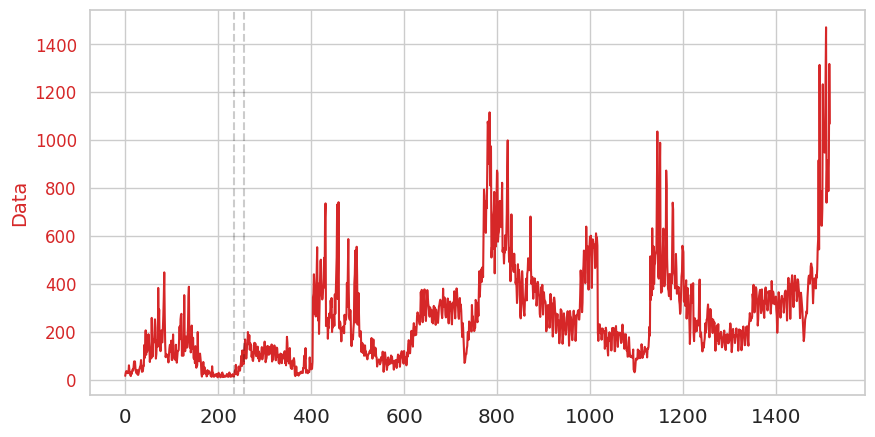

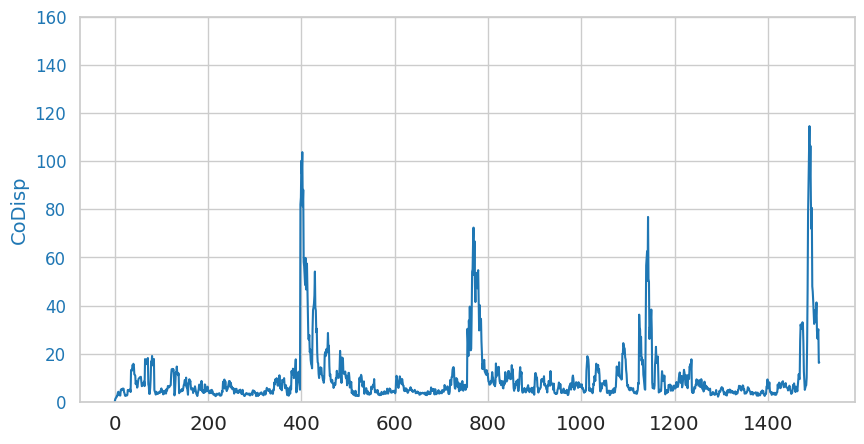

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 5))

color = "tab:red"
ax1.set_ylabel("Data", color=color, size=14)
ax1.plot(daily_visits['total_visits'], color=color)
ax1.tick_params(axis="y", labelcolor=color, labelsize=12)

fig, ax2 = plt.subplots(figsize=(10, 5))
# ax2 = ax1.twinx()
color = "tab:blue"
ax2.set_ylabel("CoDisp", color=color, size=14)
ax2.plot(pd.Series(avg_codisp).sort_index(), color=color)
ax2.tick_params(axis="y", labelcolor=color, labelsize=12)
ax2.grid("off")
ax2.set_ylim(0, 160)

for border in [235, 255]:
    ax1.axvline(border, color="black", ls="--", alpha=0.2)

## Интерпретация аномалий (онлайн):
все аномалии связаны с началом четного семестра и увеличением количества пользователей, причем еще виден спад через 1-2 месяца когда начинаются контрольные, что в общем-то почти повторяет аномалии оффлайн методов

**Вывод:**
Научились детектировать аномалии автоматически, с помощью оффлайн и онлайн метода, результаты почти совпадают, однако оффлайн методы находят аномалии чуть лучше, это связано с тем что они знают данные не только до конкретной точки, но и после нее

Изолирующий лес, ровно как и DBSCAN хорошо себя показывают в поиске аномалий

---

### Задача 2

Будем работать с [данными](https://www.kaggle.com/c/demand-forecasting-kernels-only/overview) соревнования по прогнозированию спроса на товары. Рассмотрим 5 некоторых магазинов и 20 товаров, которые продаются в них. Таким образом, будем работать с 100 временными рядами. Как и до этого, разделим данные на обучение и тест, оставив для прогнозирования 365 последних измерений.

Реализуем и сравним следующие подходы к прогнозированию:

* Одна модель на все временные ряды
* Одна модель на товар, идентификатор магазина можно использовать как признак.
* Одна модель на магазин, идентификатор товара можно использовать как признак.
* Одна модель на каждый временной ряд, итого 100 моделей.

In [ ]:
data = pd.read_csv(
    "/kaggle/input/sales-forecast-timeseries/train (1).csv", parse_dates=["date"]
)

data = data.query('(store <= 5) & (item <= 20)')
data['store'].nunique(), data['item'].nunique()

data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [ ]:
data["segment"] = (
    data["store"].astype(str).str.cat(data["item"].astype(str), sep="_")
)
data.head()

,date,store,item,sales,segment
0,2013-01-01,1,1,13,1_1
1,2013-01-02,1,1,11,1_1
2,2013-01-03,1,1,14,1_1
3,2013-01-04,1,1,13,1_1
4,2013-01-05,1,1,10,1_1


In [ ]:
data.rename({"date": "timestamp"}, axis=1, inplace=True)
data.head()

,timestamp,store,item,sales,segment
0,2013-01-01,1,1,13,1_1
1,2013-01-02,1,1,11,1_1
2,2013-01-03,1,1,14,1_1
3,2013-01-04,1,1,13,1_1
4,2013-01-05,1,1,10,1_1


In [ ]:
data.rename({"sales": "target"}, axis=1, inplace=True)
data.head()

,timestamp,store,item,target,segment
0,2013-01-01,1,1,13,1_1
1,2013-01-02,1,1,11,1_1
2,2013-01-03,1,1,14,1_1
3,2013-01-04,1,1,13,1_1
4,2013-01-05,1,1,10,1_1


In [ ]:
data_endog = data[["timestamp", "segment", "target"]]
data_exog = data[["timestamp", "segment", "store", "item"]]

In [ ]:
ts = TSDataset(df=data_endog, freq="D")
ts.head()

segment,1_1,1_10,1_11,1_12,1_13,1_14,1_15,1_16,1_17,1_18,...,5_19,5_2,5_20,5_3,5_4,5_5,5_6,5_7,5_8,5_9
feature,target,target,target,target,target,target,target,target,target,target,...,target,target,target,target,target,target,target,target,target,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2013-01-01,13,37,37,33,37,22,42,14,13,38,...,20,26,20,14,4,9,20,21,30,21
2013-01-02,11,34,43,35,31,35,33,11,18,51,...,12,22,14,16,5,5,15,16,23,20
2013-01-03,14,32,34,41,50,26,45,12,15,42,...,17,26,29,15,8,3,37,25,37,15
2013-01-04,13,45,52,45,45,32,39,15,19,50,...,24,23,16,15,7,12,33,28,39,20
2013-01-05,10,35,45,46,49,31,47,22,16,56,...,17,22,14,10,7,8,20,32,37,23


In [ ]:
HORIZON = 365

In [ ]:
data_endog_one_segment = data_endog[data_endog["segment"] == "1_1"]
ts_one_segment = TSDataset(
    df=TSDataset.to_dataset(data_endog_one_segment), freq="D"
)

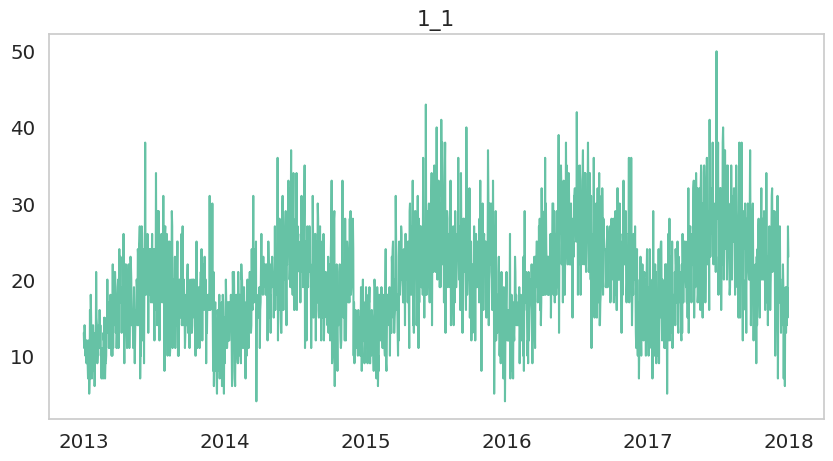

In [ ]:
ts_one_segment.plot()

In [ ]:
from etna.transforms import LagTransform, LambdaTransform
from etna.models import CatBoostPerSegmentModel, CatBoostMultiSegmentModel
from etna.pipeline import Pipeline
from etna.metrics import MAE

In [ ]:
ts

segment,1_1,1_10,1_11,1_12,1_13,1_14,1_15,1_16,1_17,1_18,...,5_19,5_2,5_20,5_3,5_4,5_5,5_6,5_7,5_8,5_9
feature,target,target,target,target,target,target,target,target,target,target,...,target,target,target,target,target,target,target,target,target,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2013-01-01,13,37,37,33,37,22,42,14,13,38,...,20,26,20,14,4,9,20,21,30,21
2013-01-02,11,34,43,35,31,35,33,11,18,51,...,12,22,14,16,5,5,15,16,23,20
2013-01-03,14,32,34,41,50,26,45,12,15,42,...,17,26,29,15,8,3,37,25,37,15
2013-01-04,13,45,52,45,45,32,39,15,19,50,...,24,23,16,15,7,12,33,28,39,20
2013-01-05,10,35,45,46,49,31,47,22,16,56,...,17,22,14,10,7,8,20,32,37,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,14,55,43,47,49,42,62,16,29,54,...,20,31,37,21,12,16,26,38,40,30
2017-12-28,19,63,64,49,68,51,82,24,13,69,...,26,33,29,26,15,10,38,39,51,24


## Одна модель на все временные ряды:

In [ ]:
HORIZON = 365
model_all = CatBoostMultiSegmentModel()
transforms = [
    YeoJohnsonTransform(in_column="target", inplace=True),
    LagTransform(
        in_column="target",
        lags=[HORIZON + i for i in range(30)],
        out_column="lag",
    ),
    DateFlagsTransform(
        day_number_in_week=True,
        day_number_in_month=True,
        is_weekend=True,
        out_column="date_flag",
    ),
    FourierTransform(period=365, order=20),
    MeanTransform(in_column=f"lag_{HORIZON}", window=10, seasonality=7),
    SegmentEncoderTransform()
]

In [ ]:
pipeline = Pipeline(model=model_all, transforms=transforms, horizon=HORIZON)

metrics_df_all, forecast_df_all, fold_info_df_all = pipeline.backtest(
    ts=ts, metrics=[MSE(), MAE(), MAPE()], n_jobs=-1, n_folds=1
)

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 4 concurrent workers.
/usr/local/lib/python3.10/dist-packages/etna/datasets/utils.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_long["segment"] = np.repeat(a=segments, repeats=n_timestamps)
/usr/local/lib/python3.10/dist-packages/etna/datasets/utils.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_long["segment"] = np.repeat(a=segments, repeats=n_timestamps)
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.1min
[Para

In [ ]:
metrics_df_all

,segment,MSE,MAE,MAPE,fold_number
0,1_1,23.068231,3.799824,18.336455,0
1,1_10,100.262370,7.969526,11.142676,0
2,1_11,94.217465,7.324298,10.269733,0
3,1_12,96.800606,7.621389,11.024119,0
4,1_13,117.147809,8.701492,10.251702,0
...,...,...,...,...,...
95,5_5,17.063097,3.304436,22.741258,0
96,5_6,68.852361,6.422133,13.320887,0
97,5_7,64.737997,6.041043,11.970575,0
98,5_8,100.178394,7.789650,12.007983,0


## По магазину:

In [ ]:
model_store = []
metrics_store = []
for store in tqdm(data_exog['store'].unique()):
    ts_s = TSDataset(data_endog[data_exog['store'] == store], freq='D')
    model = CatBoostMultiSegmentModel()
    pipeline = Pipeline(model, transforms, HORIZON)
    metrics_store, _, _ = pipeline.backtest(ts_s, metrics=[MAE(), MAE(), MAPE()], n_folds=1, n_jobs=-1)
    metrics_store.append(metrics_store)
    model_store.append(model)

100%|██████████| 5/5 [02:08<00:00, 25.61s/it]


Посмотрим на работу:

In [ ]:
store = pd.concat(metrics_store, ignore_index=True).sort_values('segment')
store['segment', 'MAE', 'fold_number']

,segment,MAE,fold_number
0,1_1,3.808854,0
1,1_10,7.671995,0
2,1_11,6.724544,0
3,1_12,6.927140,0
4,1_13,7.662885,0
...,...,...,...
95,5_5,3.322375,0
96,5_6,6.013710,0
97,5_7,5.927058,0
98,5_8,7.362774,0


## По товару:

In [ ]:
model_item = []
metrics_item = []
for item in tqdm(data_exog['item'].unique()):
    ts_iem = TSDataset(data_endog[data_exog['item'] == item], freq='D')
    model = CatBoostMultiSegmentModel()
    pipeline = Pipeline(model, transforms, HORIZON)
    metrics_item, _, _ = pipeline.backtest(ts_item, metrics=[MAE(), MAE(), MAPE()], n_folds=1, n_jobs=-1)
    metrics_item.append(metrics_item)
    model_item.append(model)

100%|██████████| 20/20 [04:34<00:00, 13.74s/it]


In [ ]:
item = pd.concat(metrics_item, ignore_index=True).sort_values('segment')
item['segment', 'MAE', 'fold_number']

,segment,MAE,fold_number
0,1_1,3.861784,0
45,1_10,7.611691,0
50,1_11,6.746988,0
55,1_12,6.663558,0
60,1_13,7.708909,0
...,...,...,...
24,5_5,3.280660,0
29,5_6,6.061354,0
34,5_7,5.696064,0
39,5_8,7.270761,0


## По магазину и товару:

In [ ]:
model_segment = []
metrics_segment = []
for segment in tqdm(data_endog['segment'].unique()):
    ts_seg = TSDataset(data_endog[data_endog['segment'] == segment], freq='D')
    model = CatBoostPerSegmentModel()
    pipeline = Pipeline(model, transforms[:-1], HORIZON)
    metrics_segment, _, _ = pipeline.backtest(ts_seg, metrics=[MAE(), MAE(), MAPE()], n_folds=1, n_jobs=-1)
    metrics_segment.append(metrics_segment)
    model_segment.append(model)

100%|██████████| 100/100 [13:50<00:00,  8.31s/it]


In [ ]:
segment = pd.concat(metrics_segment, ignore_index=True).sort_values('segment')
segment['segment', 'MAE', 'fold_number']

,segment,MAE,fold_number
0,1_1,4.007555,0
45,1_10,7.927902,0
50,1_11,7.098700,0
55,1_12,7.580580,0
60,1_13,8.008215,0
...,...,...,...
24,5_5,3.511663,0
29,5_6,6.280234,0
34,5_7,5.959158,0
39,5_8,8.189659,0


## Результат:

In [ ]:
metrics_df_all.rename(columns={'MAE': 'all'}, inplace=True)
item.rename(columns={'MAE': 'item'}, inplace=True)
store.rename(columns={'MAE': 'store'}, inplace=True)
segment.rename(columns={'MAE': 'each'}, inplace=True)
results = pd.concat([metrics_df_all[['segment', 'all']],item['item'],store['store'],segment['each']], axis=1)
results['segment', 'all', 'item', 'store', 'each']

,segment,all,item,store,each
0,1_1,3.860261,3.861784,3.808854,4.007555
1,1_10,7.606970,4.708567,7.671995,4.799807
2,1_11,6.802780,4.437995,6.724544,4.523202
3,1_12,6.780157,4.470238,6.927140,4.676506
4,1_13,7.354270,3.680685,7.662885,3.920364
...,...,...,...,...,...
95,5_5,3.265550,6.047930,3.322375,6.411553
96,5_6,5.957660,6.880798,6.013710,7.209299
97,5_7,5.755905,6.694443,5.927058,6.902625
98,5_8,7.153828,6.464798,7.362774,6.767818


**Вывод:**
* Видно что в целом, лучшее предсказание по товару по всем магазинам, это странно, но однако учитывая то, что датасет небольшой это логично - модель лучше обобщает конкретный ряд из информации от этого же товара в других магазинах
* Почти всегда худшее предсказание по магазину из-за таких же причин как в пункте выше
* Etna - удобный инструмент для быстрого обучения временных рядов, с простым трансформированием данных, таких как добавление лагов